# **OIR MKID Replacement**

**Goal** <br>
Generate synthetic IQ data with an appropriate power spectrum. Then train a ML algorithm to replace OIR MKID real time data processing, aiming to replace IQ low pass filters, conversion to phase, optimal filtering, and triggering with a single ML model. 

**Acknowledgements**<br>
Thank you to Dr. Brandt and Dr. Mazin for their patience, suggestions, advice, help, and mentorship. <br>

*-Dylan Herman*









# **Import Statements**

In [36]:
import tensorflow as tf
import numpy as np
import matplotlib, scipy
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from scipy.signal import find_peaks


print("Tensorflow Version: " +  tf.__version__)
print("Numpy Version: "  + np.__version__)
print("Matplotlib Version: " + matplotlib.__version__)
print("Scipy Version: " + scipy.__version__)

Tensorflow Version: 2.8.2
Numpy Version: 1.21.6
Matplotlib Version: 3.2.2
Scipy Version: 1.4.1


# **Data Generation**

**Loading Data**

In [3]:
datadir  = '/content/drive/MyDrive/Coursework/Google Colab/OIR MKID Replacement/' #this line is the filepath in my personal google drive

def plotPulse(I,Q,I_trace,Q_trace):
  plt.plot(I,Q)
  plt.title('I Q data')
  plt.show()
  plt.title('I Q trace data')
  plt.scatter(I_trace,Q_trace,s=0.25,c='red')

# Load sweep data
sweep = np.load(datadir+'sweep.npz')
f = sweep['f']
z = sweep['z']
I = z.real
Q = z.imag


# Load all wavelengths
fnames = ['808nm.npz','920nm.npz','980nm.npz','1120nm.npz','1310nm.npz']
i_trace = []
q_trace = []
peak_heights = []
peak_indices = []
filtered_data = []
for i in range(5):
    data = np.load(datadir+fnames[i])
    i_trace.append(data['i_trace'])
    q_trace.append(data['q_trace'])
    filtered_data.append(data['filtered_data'])
    peak_heights.append(data['peak_heights'])
    peak_indices.append(data['peak_indices'])
    data_size = data['i_trace'][:,0].size

i_trace = np.array(i_trace)
q_trace = np.array(q_trace)
filtered_data = np.array(filtered_data)

# Create Fake Data Stream
SampRate = 2000000       # Sample rate is 2 MHz
TrainingTime = 0.01      # Training data set length in sec
PhotonRate = 1000.0      # Photon Arrival rate in photons/sec
N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
photon_prob = PhotonRate/SampRate #The probability that a photon is incident at a given time_datapoint


i_train=np.zeros(N_time_datapoints)
q_train=np.zeros(N_time_datapoints)
label=np.zeros(N_time_datapoints)
peaks=np.zeros(N_time_datapoints,dtype=int)
time = np.linspace(0,TrainingTime,N_time_datapoints)



**Mapping Function + Data Visualization**

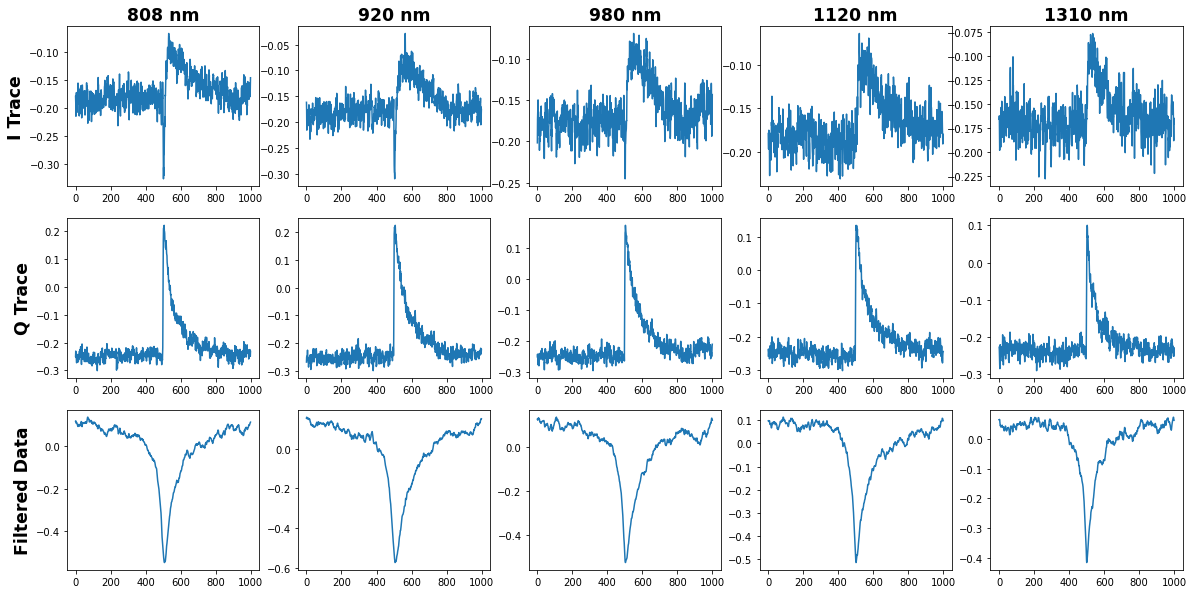

In [4]:
def mapping(i_trace, q_trace, n_pts):
    #unravel the data to get an array of 50,000 first values, and 50,000 last values
    first_val_i = i_trace[:,:,0].ravel()
    last_val_i = i_trace[:,:,n_pts].ravel()

    first_val_q  = q_trace[:,:,0].ravel()
    last_val_q = q_trace[:,:,n_pts].ravel()
    
    seed_mapping = []
    pulse_mapping = []
    for i in range(len(first_val_i)):
        comparison = np.abs(last_val_i - first_val_i[i])**2 + np.abs(last_val_q - first_val_q[i])**2 #determine least squares i/q channel comparison
        index = np.where(comparison == min(comparison)) #now index is a list of number(s) between 0 and 49,999 
        index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array
        
        #if there are multiple indices which satisfy the least squares comparison, select one at random. Ensure index is typecast from tuple to int
        if len(index) > 1:
          choice = np.random.randint(0,len(index))
          index = int(index[choice])
        else:
          index = int(index)
        

        seed = index//10000 #determines the seed index(an integer between 0 and 4) from the index through floor division
        pulse = index - seed*10000 #determines the pulse index(an integer between 0 and 9,999) by subtracting previous seed's pulses
        
        seed_mapping.append(seed)
        pulse_mapping.append(pulse)
    
    return seed_mapping, pulse_mapping

#Given a seed and pulse number, returns the index within the mapping array that corresponds to that seed/pulse
def index_to_mapping(seed, pulse):
    mapping = seed*10000 + pulse
    return mapping
  
  
#Plot first pulse in i_trace, q_trace, and filtered_data for each provided wavelength 
t = np.arange(1000) #get time axis in terms of number of points to see what a reasonable estimate for n_pts is
fig, ax = plt.subplots(3,5, figsize = (20,10))
row = ["I Trace","Q Trace","Filtered Data"]
col = ['808 nm','920 nm','980 nm','1120 nm','1310 nm']
for i in range(3):
  ax[i,0].set_ylabel(row[i], rotation = 90, fontweight = "bold", size = 'xx-large')
for i in range(5):
  ax[0,i].plot(t, i_trace[i,0,:])
  ax[1,i].plot(t, q_trace[i,0,:])
  ax[2,i].plot(t, filtered_data[i,0,:])
  ax[0,i].set_title(col[i], fontweight = "bold", size = 'xx-large')
  




**Generating Mapping**

In [5]:
n_pts = 100
seed_mapping, pulse_mapping = mapping(i_trace, q_trace, n_pts)

Generating the least squares mapping and loading the data takes around ~3 minutes, so it is it's own cell.

**Baselevel Noise Generation** <br>
This cell overwrites the arrays of zero with a noise spectrum generated by stitching together the first `n_pts` of noise from the peak data

In [6]:
#creating base level noise in i_trace, q_trace, and label from pulse data/mapping
pos = 0
pulse = np.random.randint(data_size) #choose a random pulse for a given wavelength
seed = np.random.randint(0,4) #choose a random wavelength of light to include from 5 files
while pos <= N_time_datapoints - n_pts:
    index = index_to_mapping(seed, pulse)
    i_train[pos:pos+n_pts] = i_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
    q_train[pos:pos+n_pts] = q_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
    pulse = pulse_mapping[index]
    seed = seed_mapping[index]
    pos += n_pts


**Noise and Power Spectral Density Visualization**

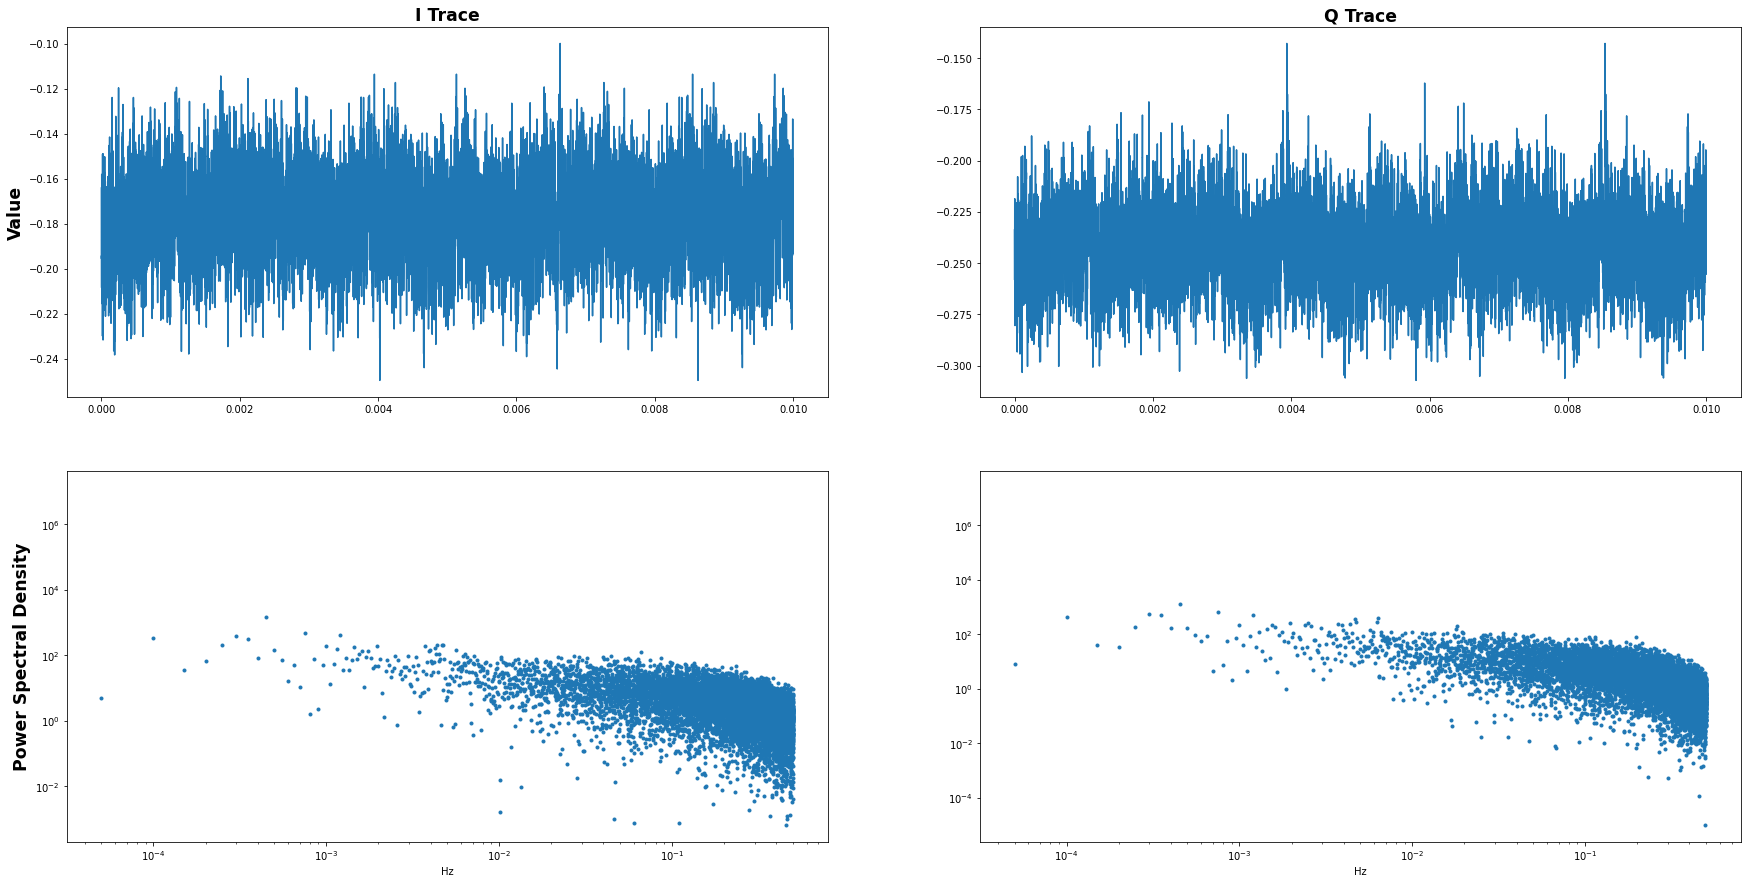

In [7]:
fig, ax = plt.subplots(2,2,figsize = (30,15))

#Fourier Transform stuff
freq = np.fft.fftfreq(len(time))
powerspec_i = np.abs(np.fft.fft(i_train))**2
powerspec_q = np.abs(np.fft.fft(q_train))**2



#Row labels
ax[0,0].set_ylabel("Value",fontweight = "bold",size = 'xx-large', rotation = 90)
ax[1,0].set_ylabel("Power Spectral Density",fontweight = "bold",size = 'xx-large', rotation = 90)

#Column labels
ax[0,0].set_title("I Trace",fontweight = "bold", size = 'xx-large')
ax[0,1].set_title("Q Trace",fontweight = "bold", size = 'xx-large')


#x_label + x_lims
for i in range(2):
  for j in range(2):
    ax[1,j].set_xlabel("Hz")
    #ax[1,j].set_xlim(left=0,right =0.5)
    
    

#I_trace
ax[0,0].plot(time, i_train)
ax[1,0].loglog(freq,powerspec_i,linestyle = '', marker = '.')


#Q_trace
ax[0,1].plot(time, q_train)
ax[1,1].loglog(freq,powerspec_q, linestyle = '', marker = '.')


plt.show()

**Synthetic Data Generation**<br>
This cell redoes the noise generation from earlier, but now at each discrete time step has a probability of `photon_prob` to insert a photon detection.


In [8]:
'''
Function that takes an initial value in i, q, and label and returns the seed and pulse indices of the dataset closest to those initial values
'''
def insert_index(i_insertion_val,q_insertion_val,i_trace,q_trace, peak_indices,halfwidth,insert_peak=bool):
        '''
        Generate first_vals_i, first_vals_q, and first_vals_label if inserting noise
        '''
        if insert_peak == False:
          first_vals_i = i_trace[:,:,0].ravel()
          first_vals_q = q_trace[:,:,0].ravel()
          #generate comparison
          comparison = np.abs(first_vals_i - i_insertion_val)**2 + np.abs(first_vals_q - q_insertion_val)**2

        '''
        Generate first_vals_i, first_vals_q, and first_vals_label if inserting a peak
        '''
        if insert_peak == True: 
          peak_start_val_i = []
          peak_start_val_q = []

          #shape(i_trace)[0] is number of wavelengths, shape(i_trace)[1] is number of pulses in a given wavelength dataset
          for i in range(np.shape(i_trace)[0]):  
            for j in range(np.shape(i_trace)[1]):
              val_i = i_trace[i,j,peak_indices[i][j] - halfwidth]
              val_q = q_trace[i,j,peak_indices[i][j] - halfwidth]
              
              peak_start_val_i.append(val_i)
              peak_start_val_q.append(val_q)
          
          #generate comparison
          comparison = np.abs(peak_start_val_i - i_insertion_val)**2 + np.abs(peak_start_val_q - q_insertion_val)**2 

        '''
        Figure out the index that minimizes the generated comparison
        '''
        
        index = np.where(comparison == min(comparison)) #now index is a list of number(s) between 0 and 49,999 
        index = np.array(index).ravel() #takes array nestled within list and turns it into a 2d array, then unravels it into a 1D array

        #if there are multiple indices which satisfy the least squares comparison, select one at random. Ensure index is typecast from tuple to int
        if len(index) > 1:
          choice = np.random.randint(0,len(index))
          index = int(index[choice])
        else:
          index = int(index)
        
        seed = index//10000 #determines the seed index(an integer between 0 and 4) from the index through floor division
        pulse = index - seed*10000 #determines the pulse index(an integer between 0 and 9,999) by subtracting previous seed's pulses

        return seed, pulse


'''
Function that Generates Synthetic Data with or without labels
'''
def synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=bool):
    #Uses SampRate, TrainingTime, and PhotonRate to generate N_time_datapoints and photon_prob
    N_time_datapoints = int(SampRate*TrainingTime) #Number of datapoints based on the training time and sample rate
    photon_prob = PhotonRate/SampRate #The probability that a photon is incident at a given time_datapoint

    
    #Initializing arrays to return
    photon_energy = np.zeros(N_time_datapoints)
    prob_incident = np.zeros(N_time_datapoints)
    i_train = np.zeros(N_time_datapoints)
    q_train = np.zeros(N_time_datapoints)

    #randomly initializing pulse and seed
    pos = 0
    pulse = np.random.randint(data_size) #choose a random pulse for a given wavelength
    seed = np.random.randint(0,4) #choose a random wavelength of light to include from 5 files
    while pos <= N_time_datapoints - n_pts:
        #If not inserting peak, continue stitching together noise
        index = index_to_mapping(seed, pulse)
        i_train[pos:pos+n_pts] = i_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
        q_train[pos:pos+n_pts] = q_trace[seed_mapping[index], pulse_mapping[index], 0:n_pts]
        pulse = pulse_mapping[index]
        seed = seed_mapping[index]
        pos += n_pts
        
        #Generates a random number drawn from a uniform distribution over [0,1) and if it's less than or equal to the probability, insert a peak. It also ensures there is enough space left in the generated data to insert a pulse 
        if np.random.rand() <= photon_prob*n_pts and pos <= N_time_datapoints - pulse_halfwidth*2: 
            #finding insertion values
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]
    
            #finding seed and pulse insert index for peak insertion
            peak_seed, peak_pulse = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = True)

            #Error checking to ensure pulse is sufficiently centered to grab a full halfwidth on either side of it. If it fails this check, returns to the beginning of the loop and does not place a pulse
            pmax = peak_indices[peak_seed][peak_pulse]
            if pmax < pulse_halfwidth or pmax > np.shape(i_trace)[2] - pulse_halfwidth:
                continue

            #inserting peak
            i_train[pos:pos+pulse_halfwidth*2] = i_trace[peak_seed, peak_pulse, pmax-pulse_halfwidth:pmax + pulse_halfwidth]
            q_train[pos:pos+pulse_halfwidth*2] = q_trace[peak_seed, peak_pulse, pmax-pulse_halfwidth:pmax + pulse_halfwidth]
            photon_energy[pos+pulse_halfwidth] = filtered_data[peak_seed, peak_pulse, pmax] #insert the peak amplitude into the label and nothing else
            prob_incident[pos+pulse_halfwidth] = 1
            pos += pulse_halfwidth*2

            #function parameters for inserting data on the other side of the peak
            i_insertion_val = i_train[pos-1]
            q_insertion_val = q_train[pos-1]

            #find seed and pulse with smallest discontinuity on the peak's tail for insertion of subsequent data
            seed, pulse = insert_index(i_insertion_val, q_insertion_val, i_trace, q_trace, peak_indices, pulse_halfwidth, insert_peak = False)

            continue

    if return_labels == True:
        label = prob_incident, photon_energy
        return i_train, q_train, label
    elif return_labels == False:
        return i_train, q_train

'''
Generating Synthetic Data Using the Functions defined above
'''
#generating training data
pulse_halfwidth = 400
i_train, q_train, label = synthetic_data_gen(i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)

#Save the training data
np.savez('training.npz',I=i_train,Q=q_train,label=label,time = time)


**Synthetic Data and Power Spectral Density Visualization**

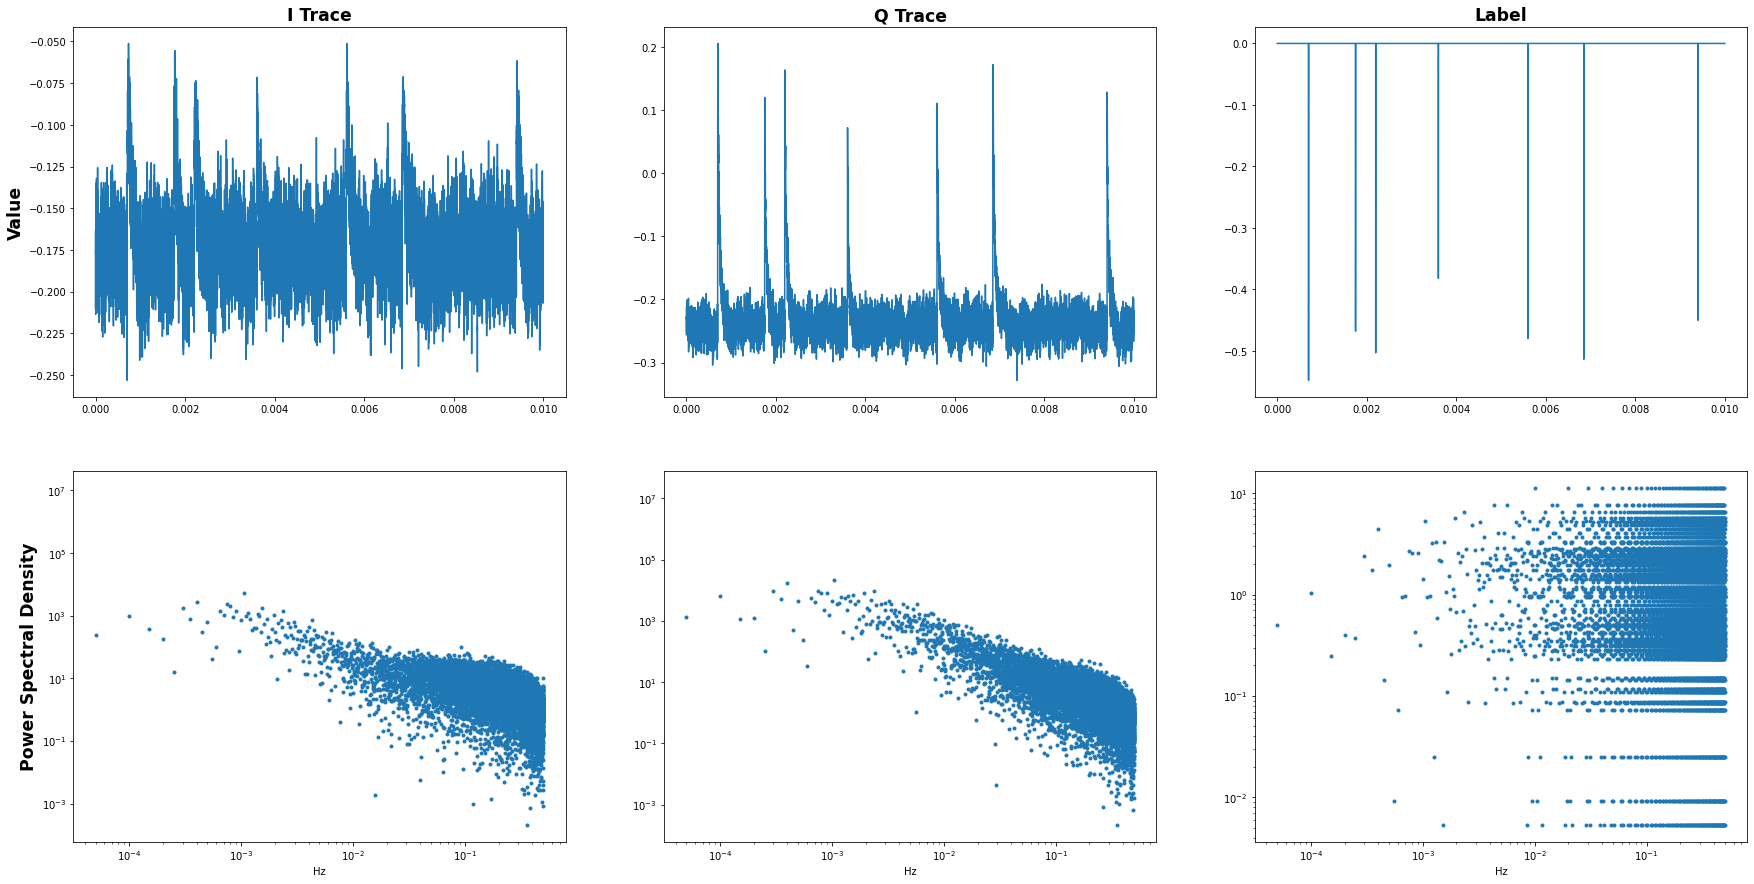

In [9]:
fig, ax = plt.subplots(2,3,figsize = (30,15))

photon_prob, photon_energy = label

#Fourier Transform stuff
freq = np.fft.fftfreq(len(time))
powerspec_i = np.abs(np.fft.fft(i_train))**2
powerspec_q = np.abs(np.fft.fft(q_train))**2
powerspec_label = np.abs(np.fft.fft(photon_energy))**2


#Row labels
ax[0,0].set_ylabel("Value",fontweight = "bold",size = 'xx-large', rotation = 90)
ax[1,0].set_ylabel("Power Spectral Density",fontweight = "bold",size = 'xx-large', rotation = 90)

#Column labels
ax[0,0].set_title("I Trace",fontweight = "bold", size = 'xx-large')
ax[0,1].set_title("Q Trace",fontweight = "bold", size = 'xx-large')
ax[0,2].set_title("Label",fontweight = "bold", size = 'xx-large')

#x_label + x_lims
for j in range(3):
    ax[1,j].set_xlabel("Hz")

#I_trace
ax[0,0].plot(time, i_train)
ax[1,0].loglog(freq,powerspec_i, linestyle = '', marker = '.')

#Q_trace
ax[0,1].plot(time, q_train)
ax[1,1].loglog(freq,powerspec_q, linestyle = '', marker = '.')

#Photon Energy
ax[0,2].plot(time,photon_energy)
ax[1,2].loglog(freq,powerspec_label, linestyle = '', marker = '.') #I don't think there's any physical meaning to be pulled from this plot

plt.show()

If there are no photons incident in the validation set (the last `1-split_fraction` datapoints in the dataset) then the early stopping callback may halt training early because validation loss isn't improving. To solve this problem, either increase `TrainingTime` so that the validation set will always contain incident photons - at the expense of computational time in training the model, or rerun the **Synthetic Generation** and **Synthetic Data and Power Spectral Density Visualization** cells to regenerate synthetic training data until the validation dataset contains incident photons.

# **Model Training**

**Data Processing** <br>
Split synthetic data set into inputs and targets, then create training and validation batches

In [10]:
def normalize(data):
  mean = np.mean(data)
  std = np.std(data)
  return (data-mean)/(std)


data = np.load('training.npz')
I = data['I']
Q = data['Q']
label = data['label']
time = data['time']



#Only normalize the input data so that the target output isn't warped
I = normalize(I)
Q = normalize(Q)
  

  
#create an array with the time data as it's 0 axis for tf.keras.utils.timeseries_dataset_from_array
input_data = np.zeros(shape=(I.size,5))
input_data[:,0] = time #time data as 0 axis for tf.keras.utils.timeseries_dataset_from_array
input_data[:,1] = I
input_data[:,2] = Q
input_data[:,3] = label[0]
input_data[:,4] = label[1]
  

#create targets array
input_targets = label[1]
  
#set up training dataset
split_fraction = 0.8
sequence_length = 100 #This hyperparameter describes how many timesteps each windowed dataset includes
batch_size = 100 #This hyperparameter describes how many datapoints the model will look at before adjusting model parameters
vector_size = input_data[0,:].size
vector_length = input_data[:,0].size
sampling_rate = 1
split_index = int(split_fraction*vector_length)
  

'''
The goal is to create a series of sequences which will be ordered so the last element of each sequence is an element of the target
dataset. The preceding elements of that sequence are elements of the input dataset. The series of sequences are chronologically 
ordered so that the first sequence contains the first (sequence_length-1) indices of the input data, and then the corresponding
element of the target data. The last sequence would then contain the last target data point and the preceding (sequence_length - 1)
datapoints.
  
Another way to think about it is like a series of sliding windows which sequentially break the input data into multiple overlapping
sequences of size (sequence_length - 1). The first window of inputs(drawn from input_data) is going to be the first (sequence_length - 1) 
indices of input_data. Then, the final index of the first window will be drawn from input_targets. Reframing the input_data and the 
input_targets allows the relevant indices to line up such so that input_targets[0] corresponds to input_data[sequence_length-1], 
and so on and so forth.

The reason for doing this is to create a timeseries dataset which will be chronologically ordered, complete with batches and targets
so that model.fit uses past timesteps and the current timestep of the input_data to predict the current timestep of the target_data.  
'''
  
  
input_targets = input_targets[sequence_length:] #reframe the target data to include everything after a sequence length's worth of time steps
input_data = input_data[:-sequence_length] #reframe the input data to include everything up to a sequence length's worth of time steps
  
  
  
'''
TRAINING DATASET
'''
dataset_train = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = input_targets,
      batch_size = batch_size, 
      sequence_length = sequence_length,
      sequence_stride = 1,
      end_index = split_index
  )


'''
VALIDATION DATASET
'''
dataset_val = tf.keras.utils.timeseries_dataset_from_array(
      data = input_data,
      targets = input_targets,
      sequence_length = sequence_length,
      batch_size = batch_size,
      sequence_stride = 1,
      start_index = split_index
  )

**Custom Loss Function** <br>


For a given range of 'true' values (a single batch of the label) this loss function backpropagates a single value. For each batch, we have five parameters we can use to describe how 'good' model predictions are. A weighted sum of these five parameters is the value returned by the `global_loss` function. 

&emsp; *Predicted Photon Count -*  $N_\gamma$ 

$$\begin{align}
N_\gamma =& \int P_\gamma  dt \\
N_\gamma =& \sum P_i\ \\
L(N_\gamma) =& (N - N_\gamma)^2
\end{align}$$
 

&emsp;  *Predicted Photon Energy -* $E_\gamma$

$$\begin{align}
E_\gamma =& \int E_\gamma P_\gamma  dt \\
E_\gamma =& \sum P_i E_i \\
L(E_\gamma) =& (E - E_\gamma)^2
\end{align}$$

&emsp;  *Variance in Predicted Energy -* $\sigma_E$

$$\begin{align}
\sigma_E =& \int (E - E_\gamma)^2 P_\gamma  dt \\
\sigma_E =& \sum (E - E_i)^2P_i \\
L(\sigma_E) =& (0 - \sigma_E)^2
\end{align}$$

&emsp;  *Predicted Photon Incidence Time -* $t_\gamma$

$$\begin{align}
t_\gamma =& \int t P_\gamma  dt \\
t_\gamma =& \sum t P_i \\
L(t_\gamma) =& (t_0 - t_\gamma)^2
\end{align}$$

&emsp;  *Variance in Predicted Time -* $\sigma_t$

$$\begin{align}
\sigma_t =& \int (t - t_\gamma)^2 P_\gamma dt \\
\sigma_t =& \sum (t - t_i)^2 P_i \\
L(\sigma_t) =& (0- \sigma_t)^2
\end{align}$$

&emsp;  *Global Loss Function*
$$L(N_\gamma, E_\gamma, \sigma_E, t_\gamma, \sigma_t) = \omega_0L(n_\gamma) + \omega_1L(E_\gamma) + \omega_2L(\sigma_E) + \omega_3L(t_\gamma) + \omega_4L(\sigma_t)$$


If the photon count is zero, then the loss from the photon count should be the only contribution to the global loss, and $\omega_1 = \omega_2 = \omega_3 =\omega_4 = 0$. Unfortunately, I could not figure out how to get the model to compile without erroring with a comparison infrastructure to determine when a photon is incident in the batch in order to set the weights to 0. The $i$th index refers to indices where photons are incident. $P_\gamma$ is the model's prediction of the probability at each batch index that a photon is incident, $E_\gamma$ is a prediction of the incident photon's energy, $t_\gamma$ is the model's prediction of the photon's incidence, and $t_0$ is the actual index at which the photon is incident. 




In [11]:
def global_loss(predicted_probability, true_energy, predicted_energy):
    #from the input data, get everything to have a shape of [None, sequence_length] None is a placeholder in graph execution for batch_size
    t = true_energy[:,:,0]
    true_probability = true_energy[:,:,3]
    true_energy = true_energy[:,:,4]
    predicted_probability = tf.squeeze(predicted_probability, axis = -1)
    predicted_energy = tf.squeeze(predicted_energy, axis = -1)
  
    #predicted photon count loss
    predicted_photon_count = tf.math.reduce_sum(predicted_probability)
    true_photon_count = tf.math.reduce_sum(true_probability)
    predicted_photon_count_loss = tf.math.square(predicted_photon_count - true_photon_count)

    #predicted photon energy loss
    predicted_photon_energy = tf.math.reduce_sum(tf.math.multiply(predicted_probability, predicted_energy))
    true_photon_energy = tf.math.reduce_sum(tf.math.multiply(true_probability, true_energy))
    predicted_photon_energy_loss = tf.math.square(predicted_photon_energy - true_photon_energy)

    #predicted energy variance loss
    predicted_energy_variance = tf.math.reduce_sum(tf.math.multiply(tf.math.square(tf.math.subtract(predicted_energy, predicted_photon_energy)), predicted_probability))
    true_energy_variance = tf.math.reduce_sum(tf.math.multiply(tf.math.square(tf.math.subtract(true_energy, true_photon_energy)), true_probability))
    predicted_energy_variance_loss = tf.square(predicted_energy_variance - true_energy_variance)

    #predicted photon incidence loss
    predicted_photon_incidence = tf.math.reduce_sum(tf.math.multiply(t, predicted_probability))
    true_photon_incidence = tf.math.reduce_sum(tf.math.multiply(t,true_probability))
    predicted_photon_incidence_loss = tf.math.square(predicted_photon_incidence - true_photon_incidence)

    #predicted time variance loss
    predicted_time_variance = tf.math.reduce_sum(tf.math.multiply(tf.math.square(tf.math.subtract(t, predicted_photon_incidence)), predicted_probability))
    true_time_variance = tf.math.reduce_sum(tf.math.multiply(tf.math.square(tf.math.subtract(t, true_photon_incidence)), true_probability))
    predicted_time_variance_loss = tf.math.square(predicted_time_variance - true_time_variance)

    #weighting
    photon_count_weight = tf.constant(1e-7) * predicted_photon_count_loss
    photon_energy_weight = tf.constant(1e-9) * predicted_photon_energy_loss
    energy_variance_weight = tf.constant(1e-9) * predicted_energy_variance_loss
    photon_incidence_weight = tf.constant(1e-9) * predicted_photon_incidence_loss
    time_variance_weight = tf.constant(1e-9) * predicted_time_variance_loss
    
    '''NEEDS TO BE FIXED'''
    #returning loss differently based on whether a photon is in the batch 
    #if tf.math.equal(true_photon_count, tf.constant(0.)):
        #global_loss = photon_count_weight
    #else:
    global_loss = photon_count_weight + photon_energy_weight + energy_variance_weight + photon_incidence_weight + time_variance_weight

    return global_loss


**Initializing Model**

In [12]:
input_shape = (sequence_length, vector_size)

#inputs to the model
energy_input = tf.keras.Input(shape = input_shape) #Timeseries dataset consisting of IQ data with a photon's energy for each window index

#convolution node with multiple inputs
energy_convolve = tf.keras.layers.Conv1D(filters = 64, kernel_size = 5, strides = 1, padding = 'causal',activation = 'relu', input_shape = input_shape)(energy_input)

#Bidirectional LSTM node with multiple inputs
energy_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True))(energy_convolve)
energy_lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True))(energy_lstm)

#output layers
probability_output = tf.keras.layers.Dense(1, activation = 'sigmoid')(energy_lstm)
energy_output = tf.keras.layers.Dense(1)(energy_lstm)

#instantiate an end-to-end model that predicts at each timestep the probability and energy
model = tf.keras.Model(
    inputs = energy_input,
    outputs = [probability_output, energy_output]
)

#Defining loss as a tensor within the model so that it can act on multiple outputs
loss = global_loss(probability_output, energy_input, energy_output)
model.add_loss(loss)

#hyperparameter
epochs = 500

#compile model
model.compile(
      optimizer='adam'
       )

**Training Model**

In [13]:
#model_checkpoint and early stopping callbacks
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("my_checkpoint.h5", save_best_only=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 30)) #figure out optimal learning rate
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience=20, restore_best_weights=True)

#fit model
history = model.fit(dataset_train, epochs=epochs,validation_data=dataset_val, callbacks=[model_checkpoint,lr_schedule,early_stopping]) 
np.save("my_history.npy", history.history)

Epoch 1/500
160/160 [==============================] - 25s 47ms/step - loss: 21968842752.0000 - val_loss: 10514362368.0000 - lr: 1.0000e-08
Epoch 2/500
160/160 [==============================] - 6s 35ms/step - loss: 21949820928.0000 - val_loss: 10503063552.0000 - lr: 1.0798e-08
Epoch 3/500
160/160 [==============================] - 6s 36ms/step - loss: 21925990400.0000 - val_loss: 10490059776.0000 - lr: 1.1659e-08
Epoch 4/500
160/160 [==============================] - 6s 36ms/step - loss: 21898756096.0000 - val_loss: 10475414528.0000 - lr: 1.2589e-08
Epoch 5/500
160/160 [==============================] - 6s 36ms/step - loss: 21868156928.0000 - val_loss: 10459049984.0000 - lr: 1.3594e-08
Epoch 6/500
160/160 [==============================] - 6s 36ms/step - loss: 21834072064.0000 - val_loss: 10440884224.0000 - lr: 1.4678e-08
Epoch 7/500
160/160 [==============================] - 6s 36ms/step - loss: 21796358144.0000 - val_loss: 10420845568.0000 - lr: 1.5849e-08
Epoch 8/500
160/160 [=====

**Training Metrics**

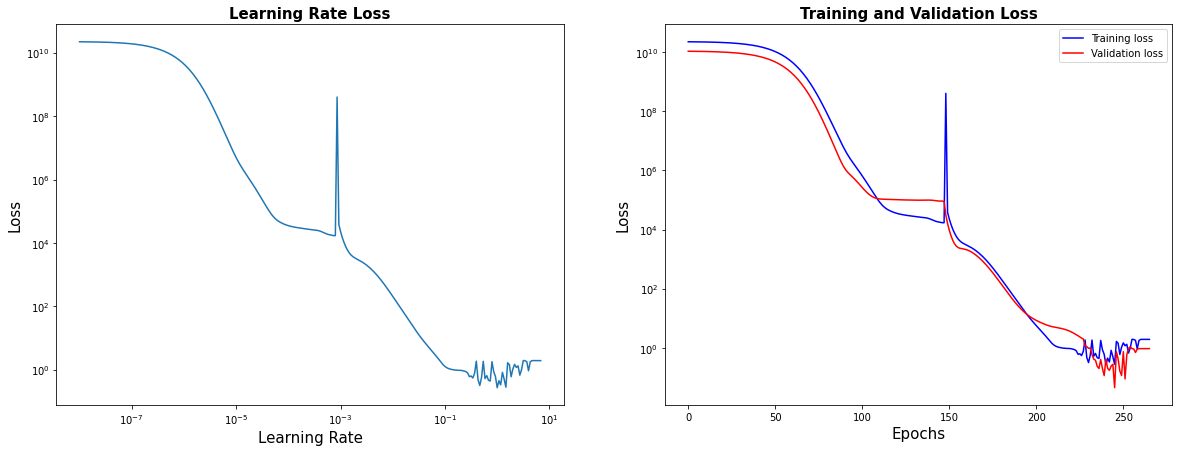

In [16]:
fig, ax = plt.subplots(1,2, figsize = (20,7))

#display Loss as a function of Learning Rate
ax[0].loglog(history.history["lr"], history.history["loss"])
ax[0].set_xlabel("Learning Rate", fontsize = 15)
ax[0].set_title("Learning Rate Loss", fontsize = 15, fontweight = 'bold')
ax[0].set_ylabel("Loss", fontsize = 15)


#Display Loss as a function of epochs
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(len(loss))
ax[1].semilogy(epochs, loss, c="b", label="Training loss")
ax[1].semilogy(epochs, val_loss,c="r", label="Validation loss")
ax[1].set_title("Training and Validation Loss", fontsize = 15, fontweight = 'bold')
ax[1].set_xlabel("Epochs", fontsize = 15)
ax[1].set_ylabel("Loss", fontsize = 15)
ax[1].legend()
plt.show()

At the beginning of training a model, the optimal learning rate for fastest convergence is unknown. We can use the learning rate scheduler to start with a small learning rate and increase it slightly each epoch in order to be able to track loss as function of learning rate (pictured above). The optimal learning rate can be estimated by eye as the point at which the loss curve flattens out, prior to it becoming unstable.

# **Model Evaluation**

**Defining `model_predictions` Function**<br>
The `model_predictions` function generates evaluation data using the `synthetic_data_gen` function defined under the **Data Generation** heading. It then generates and returns model predictions based on the evaluation data generated in the function call. 

In [85]:
def model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = bool):
    #generating evaluation data
    i_eval, q_eval, label_eval = synthetic_data_gen(i_trace, q_trace, filtered_data, peak_indices, SampRate, TrainingTime, PhotonRate, n_pts, pulse_halfwidth,return_labels=True)
    N_time_datapoints = int(SampRate*TrainingTime)
    time_eval = np.linspace(0,TrainingTime,N_time_datapoints)

    #Need to normalize and batch the evaluation data the same way as the training data
    I = normalize(i_eval)
    Q = normalize(q_eval)
    
    #from i_eval, q_eval, estimate the probability and photon energy because I couldn't figure out how to write the loss function without passing the photon energy into the input
    peak_indices, max = find_peaks(q_eval,height = 0.05,distance = 100) 
    probability_eval = np.zeros(len(time_eval)) 
    probability_eval[peak_indices] = 1 
    energy_eval = np.zeros(len(time_eval)) 
    energy_eval[peak_indices] = (i_eval[peak_indices]**2 + q_eval[peak_indices]**2)**0.5

    #building evaluation array in the same way training data for the model was built
    evaluation_array = np.zeros(shape=(I.size,5))
    evaluation_array[:,0] = time_eval #time data as 0 axis for tf.keras.utils.timeseries_dataset_from_array
    evaluation_array[:,1] = I
    evaluation_array[:,2] = Q
    evaluation_array[:,3] = probability_eval
    evaluation_array[:,4] = energy_eval

    #evaluation dataset from normalized IQ data
    dataset_eval = tf.keras.utils.timeseries_dataset_from_array(
        data = evaluation_array,
        targets = None,
        sequence_length = sequence_length,
        batch_size = batch_size,
      )

    #Generating Model Predictions
    output = model.predict(dataset_eval)

    #splitting model predictions into probability and energy
    photon_probability = output[0]
    photon_energy = output[1]

    #the 1 dimensional model prediction is at each index the predicted energy of a photon multiplied by the probability that there is indeed a photon incident
    model_prediction = photon_probability[:,0,:].ravel() * photon_energy[:,0,:].ravel()

    if return_labels == True:
        return model_prediction, label_eval
    elif return_labels == False:
        return model_prediction        

**Generating a Rescaling Factor**<br>
Model predictions need to be rescaled by a constant factor in order to be compared to label peaks. This `rescaling_factor` can be estimated by eye, but ideally, we want to determine the rescaling factor quantitatively for any set of data that the model might be asked to make predictions upon. In the next code cell, we generate evaluation data and minimize the `scaling_factor` function(which returns the least squares difference between the model's predicted peaks and the label's peaks) to obtain the best fit `rescaling_factor`. We then perform bootstrap resampling by redoing the previous step multiple times in order to recover a bootstrapped `rescaling_factor` and it's uncertainty. This bootstrapped resampled `rescaling_factor` can then be applied to all predictions made by the model. Expect this cell to take around 10 minutes to run with 50 iterations.

In [86]:
#Defining the function to minimize to obtain the scaling factor for each generated evaluation dataset
def scaling_factor(rescaling_factor, model_prediction, label_eval):
    #We want to determine the appropriate scaling factor by minimizing the least squares difference of the model and label peaks
    peak_indices = np.where(label_eval != 0)
    label_peaks = label_eval[peak_indices]
    model_peaks = model_prediction[peak_indices]

    #calculate lstsq value(to be minimized)
    lstsq =  np.sum(model_peaks*rescaling_factor - label_peaks)**2

    return lstsq

def find_best_rescaling_factor(model_prediction, label_eval):
    guess = np.random.rand() #Since we only have one parameter, our initial guess shouldn't matter
    rescaling_factor = minimize(scaling_factor, guess, args=(model_prediction, label_eval), method = "Powell").x
    return rescaling_factor

#Loading model
model = tf.keras.models.load_model('my_checkpoint.h5')
eval_TrainingTime = 0.01 #even if training the model on more than 0.01 second of training time, evaluate it on 0.01 second of traing time because it's faster
N_time_datapoints = int(SampRate*eval_TrainingTime)
time_eval = np.linspace(0,TrainingTime,N_time_datapoints)

#Performing bootstrap resampling: When generating synthetic data with a training time of 0.01 seconds, model_predictions took about 10 seconds per iteration(expect this cell to be computationally expensive)
num_iter = 25
bstrap_list = []
for i in range(num_iter):
    bstrap_model_prediction, bstrap_label = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
    rescaling_factor_i = find_best_rescaling_factor(bstrap_model_prediction, bstrap_label[1])
    bstrap_list.append(rescaling_factor_i)

bstrap_rescaling_factor = np.mean(bstrap_list)
sigma_rescaling_factor = np.std(bstrap_list)

print(f"Using bootstrap resampling with {num_iter} iterations generates a rescaling factor of {bstrap_rescaling_factor:.3f} ± {sigma_rescaling_factor:.3f}")

Using bootstrap resampling with 25 iterations generates a rescaling factor of -10.143 ± 2.742


A small range of rescaling factors from multiple iterations of model predictions on randomly created evaluation data during bootstrapping implies that the model is consistently 'off' the true values by roughly the same amount. This corresponds to the uncertainty on the bootstrap resampled rescaling factor, which therefore gives an indication of how precise (and therefore how good) the model is.

**Model Prediction + Scaling Factor Generation**

In [89]:
prediction, label_eval = model_predictions(model, i_trace,q_trace, filtered_data, peak_indices, SampRate, eval_TrainingTime, PhotonRate, n_pts, pulse_halfwidth, return_labels = True)
energy_eval = label_eval[1]
best_rescaling_factor = find_best_rescaling_factor(prediction, energy_eval)

**Prediction Visualization**

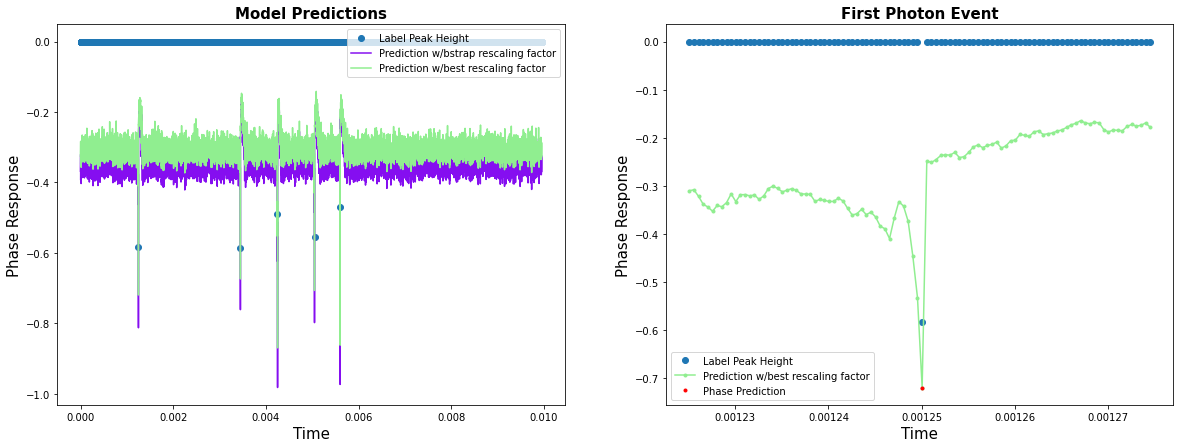

In [90]:
fig, ax = plt.subplots(1,2, figsize = (20,7))

#Plotting Model Predictions
ax[0].plot(time_eval[0:N_time_datapoints - sequence_length],energy_eval[0:N_time_datapoints - sequence_length],label = "Label Peak Height", linestyle = '', marker= 'o')
ax[0].plot(time_eval[0:N_time_datapoints - sequence_length],prediction[0:N_time_datapoints - sequence_length]*bstrap_rescaling_factor,label = "Prediction w/bstrap rescaling factor", c = '#850ef0')
ax[0].plot(time_eval[0:N_time_datapoints - sequence_length],prediction[0:N_time_datapoints - sequence_length]*best_rescaling_factor,label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[0].set_ylabel("Phase Response", fontsize = 15)
ax[0].set_xlabel("Time", fontsize = 15)
ax[0].set_title("Model Predictions", fontweight = 'bold', fontsize = 15)
ax[0].legend(loc = 'upper right')

#Zooming in on the first Photon Detection
first_photon = np.where(energy_eval != 0)[0][0] #gets index of first photon detection
ax[1].plot(time_eval[first_photon - 50:first_photon + 50],energy_eval[first_photon - 50:first_photon + 50],label = "Label Peak Height", linestyle = '', marker= 'o')
ax[1].plot(time_eval[first_photon - 50:first_photon + 50],prediction[first_photon - 50:first_photon + 50]*best_rescaling_factor,marker = '.',label = "Prediction w/best rescaling factor", c = 'lightgreen')
ax[1].plot(time_eval[first_photon], prediction[first_photon]*best_rescaling_factor, label = "Phase Prediction", linestyle = '', marker = '.', color = 'red')
ax[1].set_ylabel("Phase Response", fontsize = 15)
ax[1].set_xlabel("Time", fontsize = 15)
ax[1].set_title("First Photon Event", fontweight = 'bold', fontsize = 15)
ax[1].legend()

plt.show()


# **Appendix**

Over the course of this project, there came several times when I encountered an error that I thought could not be resolved without significantly rewriting large swathes of the code. In order to preserve things I replaced on the chance they be reprised later, I have stored them here in the appendix. Most of the code here will not work with the code above or does not work outright, so replace things at your own risk.

**Deprecated Custom Loss Functions**

The `peak_loss` function penalizes the model for failing to match the label values when the label value corresponds to a photon peak. It's internal logic relies on the label having a value of zero at indices where photons are not incident. Though this function is only 22 lines long (excluding comments and whitespace), it took me nearly 18 hours of coding to implement it successfully. It says something about me that the most exciting event of my life in recent memory was it running without erroring, but that's a problem for someone with a degree in psychology. 

In [ ]:
def peak_loss(y_actual, y_pred):
    '''
    Reshaping Everything to a Rank One Tensor(vector) of length batch_size*sequence_length so I don't have an aneurysm trying to debug this
    '''
    #reshape y_actual and y_pred to have shape[batch_size, sequence_length]
    y_actual = tf.stack([y_actual]*sequence_length, axis = -1) #y_actual has shape [batch_size] and needs to be stacked sequence_length times
    y_pred = tf.squeeze(y_pred) #y_pred has shape[batch_size, sequence_length, 1], squeeze reduces it to a rank-2 tensor
    
    #now reshape y_actual and y_pred to both be rank 1 tensors of length batch_size*sequence_length
    y_actual = tf.reshape(y_actual, shape = [-1])
    y_pred = tf.reshape(y_pred, shape = [-1])

    #To make sure the scattered tensors are the right shapes, define a shape of length batch_size*sequence_length to be used later
    shape = tf.constant([batch_size*sequence_length])
    
    '''
    Creating Loss Tensor for indices where photons are incident
    '''
    #Obtaining indices where photons are incident
    peak_indices = tf.where(y_actual != 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    peak_indices = tf.cast(peak_indices, dtype = tf.int32) 

    #calculating loss at peak indices and creating a zero-initialized tensor with loss at the peak indices
    peak_loss = tf.math.square(tf.gather(y_actual,peak_indices) - tf.gather(y_pred,peak_indices)) #vstacks tf.gathered values
    peak_loss = tf.squeeze(peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    peak_loss_tensor = tf.scatter(peak_indices, peak_loss, shape)

    '''
    Creating Loss Tensor for indices where photons are NOT incident
    '''
    #Obtaining indices where photons are not incident
    non_peak_indices = tf.where(y_actual == 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    non_peak_indices = tf.cast(non_peak_indices, dtype = tf.int32) 
    
    #calculating loss at those indices
    non_peak_weight = tf.constant(0.01) #We don't really care about minimizing loss when not at a peak so we give this loss a small weight
    non_peak_loss = tf.math.square(tf.gather(y_actual,non_peak_indices) - tf.gather(y_pred,non_peak_indices))
    non_peak_loss = tf.scalar_mul(non_peak_weight, non_peak_loss)
    non_peak_loss = tf.squeeze(non_peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    non_peak_loss_tensor = tf.scatter(non_peak_indices, non_peak_loss, shape)

    '''
    Summing the two sparse loss tensors together to obtain a full loss tensor and acquire the mean loss for each y_actual
    '''
    full_loss_tensor = peak_loss_tensor + non_peak_loss_tensor
    
    return full_loss_tensor


The `adjacent_loss` function penalizes the model for failing to match the label at peak indices and at a given number of indices that are adjacent to the peak indices. It currently does not run without erroring. 

In [ ]:
def adjacent_indices(index):                                                                                                                                                                   
    #If there is a peak in the index, the index passed here will not be empty
    if tf.shape(index)[0] != 0:

        # reshape for tiling purposes
        index = tf.reshape(index, shape = [-1]) 
        
        #depending on the index's location with respect to the window, decide how many adjacent indices to include
        if index == tf.constant(0):
            a = tf.tile(index, [3])                                                                                                                                                     
            b = tf.constant([0, 1, 2], shape=[3, 1], dtype=tf.int32)                                                                                                               
            sliced = tf.slice((a + b), begin=[0,0], size=[3, 1]) 

        elif index == tf.constant(1):
            a = tf.tile(index, [4])                                                                                                                                                     
            b = tf.constant([-1, 0, 1, 2], shape=[4, 1], dtype=tf.int32)                                                                                                               
            sliced = tf.slice((a + b), begin=[0,0], size=[4, 1])

        elif index == tf.constant(batch_size*sequence_length - 2):
            a = tf.tile(index, [4])                                                                                                                                                     
            b = tf.constant([-2,-1, 0, 1], shape=[4, 1], dtype=tf.int32)                                                                                                               
            sliced = tf.slice((a + b), begin=[0,0], size=[4, 1])

        elif index == tf.constant(batch_size*sequence_length-1):
            a = tf.tile(index, [3])                                                                                                                                                     
            b = tf.constant([-2,-1, 0], shape=[3, 1], dtype=tf.int32)                                                                                                               
            sliced = tf.slice((a + b), begin=[0,0], size=[3, 1])

        else:
            a = tf.tile(index, [5])                                                                                                                                                     
            b = tf.constant([-2, -1, 0, 1, 2], shape=[5, 1], dtype=tf.int32)                                                                                                               
            sliced = tf.slice((a + b), begin=[0,0], size=[5, 1]) 
    
        return sliced

    #if index is empty, return the index
    else: 
        return index

    

def adjacent_loss(y_actual, y_pred):
    '''
    Reshaping Everything to a Rank One Tensor(vector) of length batch_size*sequence_length so I don't have an aneurysm trying to debug this
    '''
    #reshape y_actual and y_pred to have shape[batch_size, sequence_length]
    y_actual = tf.stack([y_actual]*sequence_length, axis = -1) #y_actual has shape [batch_size] and needs to be stacked sequence_length times
    y_pred = tf.squeeze(y_pred) #y_pred has shape[batch_size, sequence_length, 1], squeeze reduces it to a rank-2 tensor
    
    #now reshape y_actual and y_pred to both be rank 1 tensors of length batch_size*sequence_length
    y_actual = tf.reshape(y_actual, shape = [-1])
    y_pred = tf.reshape(y_pred, shape = [-1])

    #To make sure the scattered tensors are the right shapes, define a shape of length batch_size*sequence_length to be used later
    shape = tf.constant([batch_size*sequence_length])
    
    '''
    Creating Loss Tensor for indices where photons are incident
    '''
    #Obtaining indices where photons are incident
    peak_indices = tf.where(y_actual != 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    peak_indices = tf.cast(peak_indices, dtype = tf.int32) 
    peak_indices = adjacent_indices(peak_indices)
    

    #calculating loss at peak indices and creating a zero-initialized tensor with loss at the peak indices
    peak_loss = tf.math.square(tf.gather(y_actual,peak_indices) - tf.gather(y_pred,peak_indices)) #vstacks tf.gathered values
    peak_loss = tf.squeeze(peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    peak_loss_tensor = tf.scatter(peak_indices, peak_loss, shape)

    '''
    Creating Loss Tensor for indices where photons are NOT incident
    '''
    #Obtaining indices where photons are not incident
    non_peak_indices = tf.where(y_actual == 0) #tf.where always returns tf.int64 tensors, but we want them in tf.int32 to match the rest of our data
    non_peak_indices = tf.cast(non_peak_indices, dtype = tf.int32) 
    
    #calculating loss at those indices
    non_peak_weight = tf.constant(0.01) #We don't really care about minimizing loss when not at a peak so we give this loss a small weight
    non_peak_loss = tf.math.square(tf.gather(y_actual,non_peak_indices) - tf.gather(y_pred,non_peak_indices))
    non_peak_loss = tf.scalar_mul(non_peak_weight, non_peak_loss)
    non_peak_loss = tf.squeeze(non_peak_loss) #reduces peak_loss from a rank 2 tensor to a rank 1 tensor by removing the extra axis
    non_peak_loss_tensor = tf.scatter(non_peak_indices, non_peak_loss, shape)

    '''
    Summing the two sparse loss tensors together to obtain a full loss tensor and acquire the mean loss for each y_actual
    '''
    full_loss_tensor = peak_loss_tensor + non_peak_loss_tensor
    
    return full_loss_tensor


The `naive_loss` function penalizes the model for failing to match the label at any batch containing a peak. This essentially is a crude way to implement the `adjacent_loss` function where the adjacent indices are the entire batch size. 

In [ ]:
def naive_loss(y_actual, y_pred):
    print(tf.shape(y_actual), tf.shape(y_pred))

    peaks = tf.where(y_actual != 0) 
    
    if tf.shape(peaks)[0] != 0:
        loss = tf.keras.backend.square(y_actual - y_pred)
    else:
        weight = 0.01
        loss = tf.keras.backend.square(y_actual - y_pred)
        loss = tf.scalar_mul(weight, loss)
    return loss

**Deprecated Data Generation Structure**<br>
This data structure attempts to create windowed/batched datasets by hand rather than with the tensorflow function. Abandoned since model.fit doesn't support multiple dataset inputs; supposedly it should work if one creates a dictionary of datasets but after four hours of pain I decided to rewrite everything, *again*. I've lost count of how many times I've rewritten/restructured everything. 

In [ ]:
def normalize(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean)/(std)

def window_dataset(time_series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(time_series) #creates a dataset of tensors at each index of the time_series
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True) #calls the window method
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) #transforms the dataset into tensors elementwise
    batches = dataset.batch(batch_size) #batches the dataset
    return batches
    
data = np.load('training.npz')
I = data['I']
Q = data['Q']
label = data['label']
time = data['time']

#Only normalize the input data so that the target output isn't warped
I = normalize(I)
Q = normalize(Q)
photon_prob = label[0]
photon_energy = label[1]

#hyperparameters
sequence_length = 50
batch_size = 5
split_fraction = 0.8
length = len(I)
split_index = int(length*split_fraction)


#training data
I_train = window_dataset(I[:split_index], sequence_length, batch_size)
Q_train = window_dataset(Q[:split_index], sequence_length, batch_size)
probability_train = window_dataset(photon_prob[:split_index], sequence_length, batch_size)
energy_train = window_dataset(photon_energy[:split_index], sequence_length, batch_size)
dataset_train = {
    "I_input": I_train, 
    "Q_input": Q_train, 
    "probability_input": probability_train,
    "energy_input": energy_train
}


#training data
I_val = window_dataset(I[split_index:], sequence_length, batch_size)
Q_val = window_dataset(Q[split_index:], sequence_length, batch_size)
probability_val = window_dataset(photon_prob[split_index:], sequence_length, batch_size)
energy_val = window_dataset(photon_energy[split_index:], sequence_length, batch_size)
dataset_val = {
    "I_input": I_val,
    "Q_input": Q_val,
    "probability_input": probability_val,
    "energy_input": energy_val
}